In [11]:
from network import * 
from training import *
def plot_parallel_synapse_params(model):
    plt.figure(figsize=(12, 3))
    plt.subplot(1,4,1)
    plt.hist((model.parallel_synapse.ampli.data.cpu().numpy()**2).flatten(), bins=20)
    plt.title('Amplitude histogram')

    plt.subplot(1,4,2)
    plt.hist(model.parallel_synapse.slope.data.cpu().numpy().flatten(), bins=20)
    plt.title('Slope histogram')

    plt.subplot(1,4,3)
    plt.hist(model.parallel_synapse.thres.data.cpu().numpy().flatten(), bins=20)
    plt.title('Threshold histogram')
    
    plt.subplot(1,4,4)
    plt.hist(model.parallel_synapse.scaler.data.cpu().numpy().flatten(), bins=20)
    plt.title('Scaler histogram')
    
    plt.tight_layout()
    plt.show()


def plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act:str = 'sigmoid') -> None:
    '''
    Inputs:
        model: nn.Module
    
    '''
    hidden = []
    final = []
    for inputs, labels in testloader:
        inputs = inputs.view(-1, 28*28)#.to(device)
        
        labels = binary_labels(labels)
        if hidden_act == 'sigmoid':
            hidden.append(torch.sigmoid(model.fc1(inputs)).detach().cpu())
            
        else:
            hidden.append(torch.relu(model.fc1(inputs)).detach().cpu())
        final.append(model.parallel_synapse(hidden[-1]).detach().cpu())
    hidden = torch.cat(hidden, dim=0)
    hidden = hidden.data.cpu().numpy()
    final = torch.cat(final, dim=0)
    plt.figure(figsize=(9, 3 ))
    plt.subplot(1,3,1)
    plt.hist(hidden[hidden>0.00001].flatten(), bins=100)
    plt.title('Hidden activation, {:.1f}% > 1e-4'.format((hidden>1e-4).mean() * 100))
    plt.legend()
    plt.xlabel('hidden layer input')
    plt.ylabel('count')
    
    f = model.parallel_synapse
    slope = f.slope
    ampli = f.ampli
    thres = f.thres
    input_dim = slope.shape[1]
    n_data = 100
    output_dim = slope.shape[-1]
    input = torch.linspace(0, hidden.flatten().max(), steps=n_data).reshape(-1, 1)
    input = input.repeat(1, input_dim)
    n_data = input.shape[0]
    n_synapse = slope.shape[0]
    

    x = slope[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim) \
        * (input[:, None, :, None].expand(n_data, n_synapse, input_dim, output_dim)
        - thres[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim))
    x = torch.tanh(x)
    x = x * (ampli[None, :, :, :]**2 ).expand(n_data, n_synapse, input_dim, output_dim)
    # x = x * f.scaler[None, None, :, :].expand(n_data, n_synapse, input_dim, output_dim)
    x = x.sum(dim=1).squeeze() 
    
    
    plt.subplot(1,3,2)
    plt.hist(final.data.cpu().numpy().flatten(), bins=100, label='MNIST')
    ylim = plt.ylim()
    plt.legend()
    plt.xlabel('output')
    plt.title('Histogram, final layer input')
    
    plt.tight_layout() 
    
    plt.figure(figsize = (10, 4))
    
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.plot(input[:,0].numpy(), x.detach().numpy()[:,:,i], alpha = 0.8)
        plt.title('output-' + str(i+1))
        plt.xlabel('Input')
    plt.tight_layout()
    plt.show()

def plot_result(result):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.plot(result['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(result['accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.tight_layout()
    plt.show()

In [12]:

def multiHingeLoss(output, target, margin = 1):
    # output: (batch_size, num_classes)
    # target: (batch_size, num_classes)
    # loss: (batch_size, 1)
    loss = torch.clamp(margin - output * target, min=0)
    return loss.sum(dim=1).mean()

def oneHotLabel(label, num_classes):
    # label: (batch_size, 1)
    # one_hot_label: (batch_size, num_classes)
    batch_size = label.size(0)
    one_hot_label =(-torch.ones(batch_size, num_classes)).scatter_(1, label.view(-1, 1), 1)
    return one_hot_label

def train_models_NN(model, 
                trainloader, 
                testloader,
                regularization = 0.0,
                H = 20, 
                in_dim = 28, 
                out_dim = 10, 
                num_epochs = 20,
                verbose = True, 
                device = torch.device('cpu'),
                model_type = 'parallel'): 
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses, acc = [], []
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            if model_type == 'parallel':
                with torch.no_grad():
                    slope_thres = 0.01
                    mask = (model.parallel_synapse.slope.data < slope_thres) 
                    model.parallel_synapse.slope.data = torch.clamp(model.parallel_synapse.slope.data, min = slope_thres)
                    model.parallel_synapse.thres.data[mask] = torch.rand(mask.sum()) * model.hidden_range[1] + model.hidden_range[0]
                    
                    ampli_thres = 0.1
                    mask = (model.parallel_synapse.ampli.data**2 < ampli_thres) 
                    model.parallel_synapse.thres.data[mask] = torch.rand(mask.sum()) * model.hidden_range[1] + model.hidden_range[0]
                    model.parallel_synapse.ampli.data[mask] = np.sqrt(ampli_thres)
                    
                    # model.parallel_synapse.thres.data = torch.clamp(model.parallel_synapse.thres.data, min = model.hidden_range[0] )
        
            inputs = inputs.view(-1, 28*28).to(device)
            labels = labels.to(device)
            # labels = oneHotLabel(labels, out_dim).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.nll_loss(outputs, labels) 
            
            # loss = multiHingeLoss(outputs, labels) 
            if model_type == 'parallel':
                loss += regularization * (torch.abs(model.parallel_synapse.scaler) - 1).abs().sum()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses.append(running_loss / len(trainloader))
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.view(-1, 28*28).to(device)
                labels = oneHotLabel(labels, out_dim).to(device)
                outputs = model(inputs)
                total += labels.size(0)
                correct += torch.argmax(outputs, dim = 1).eq(torch.argmax(labels, dim = 1)).sum().item()
        acc.append(100 * correct / total )
        if verbose and epoch % 10 == 0:
            print( f" Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {acc[-1]:.2f}%")
            plot_parallel_synapse_params(model)
            plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act='relu')
    
    
    return {
            'model': model,
            'accuracy': acc,
            'loss': losses
            }

In [13]:
class ParallelSynapseLayer_FlipSign(nn.Module):
    def __init__(self, 
                input_dim: int, 
                n_synapse: int, 
                output_dim: int, 
                input_range: Tuple = (-1, 1)) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.n_synapse = n_synapse
        self.output_dim = output_dim
        
        self.thres = nn.Parameter(torch.rand(
            self.n_synapse, self.input_dim, self.output_dim) * (input_range[1] - input_range[0]) + input_range[0])
        self.slope = nn.Parameter(5*torch.rand(self.n_synapse, self.input_dim, self.output_dim))
        self.ampli = nn.Parameter(torch.rand(self.n_synapse, self.input_dim, self.output_dim))
        self.scaler = nn.Parameter(torch.rand(self.input_dim, self.output_dim))
        
    def forward(self, input: Tensor):
        '''
        Inputs:
            input: (n_data, input_dim)

        Returns:
            output: (n_data, output_dim)
        '''
        n_data = input.shape[0]
        x = self.slope[None, :, :,:].expand(n_data, self.n_synapse, self.input_dim, self.output_dim) * \
            (input[:, None, :, None].expand(n_data, self.n_synapse, self.input_dim, self.output_dim) -
            self.thres[None, :,:,:].expand(n_data, self.n_synapse, self.input_dim, self.output_dim))
        x = (self.ampli[None, :, :,:]**2).expand(n_data, self.n_synapse, self.input_dim, self.output_dim) * \
            torch.tanh(x) 
        x = x.sum(dim=(1)).squeeze()
        x = x * self.scaler[None, :, :].expand(n_data, self.input_dim, self.output_dim)
        x = x.sum(dim=(1)).squeeze() 
        return x

class ParallelSynapse2NN(nn.Module):
    def __init__(self, 
                input_dim: int, 
                n_synapse: int, 
                hidden_dim: int, 
                output_dim: int = 10, 
                hidden_range: Tuple = (0, 40)) -> None:
        super().__init__()
        self.hidden_range = hidden_range
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        self.parallel_synapse = ParallelSynapseLayer_FlipSign(hidden_dim, 
                                                n_synapse, 
                                                output_dim, 
                                                input_range = self.hidden_range)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.parallel_synapse(x)
        # return x.squeeze()
        return F.log_softmax(x, dim=1)

    

In [14]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

hidden_dim = 30
output_dim = 10
input_dim = 28*28
n_synapse = 3
hidden_range = (0, 20)


 Epoch 1/80, Loss: 0.6318, Accuracy: 90.40%


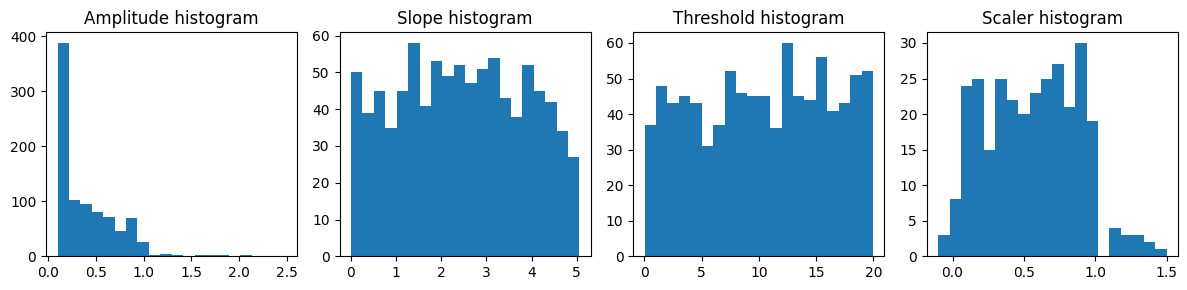

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


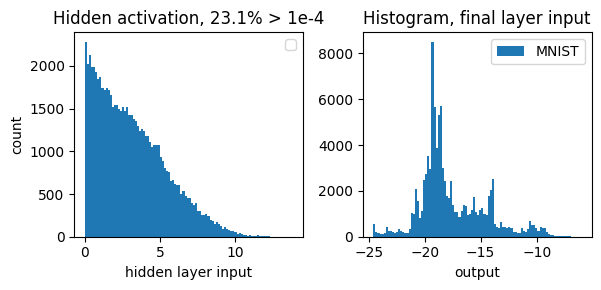

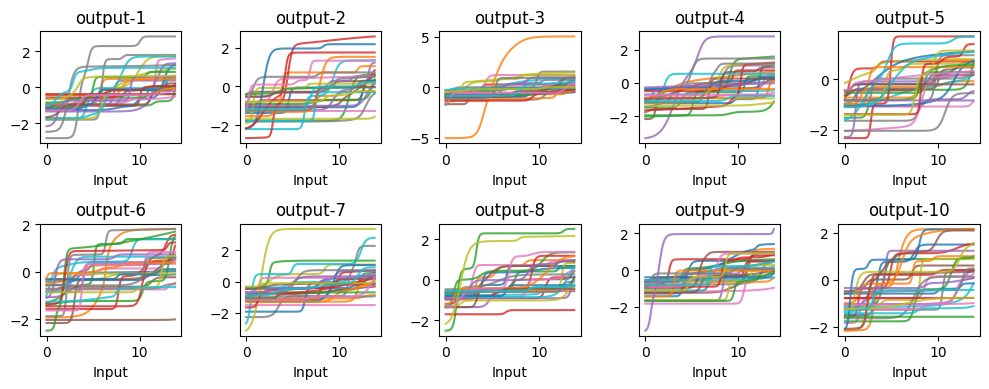

 Epoch 11/80, Loss: 0.2323, Accuracy: 93.18%


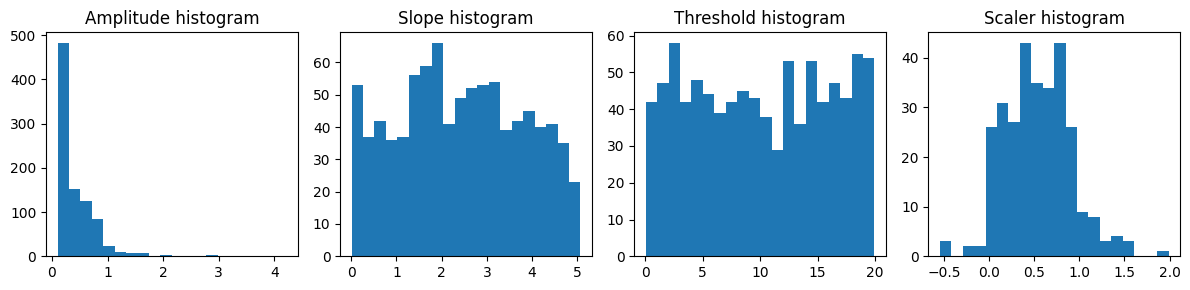

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


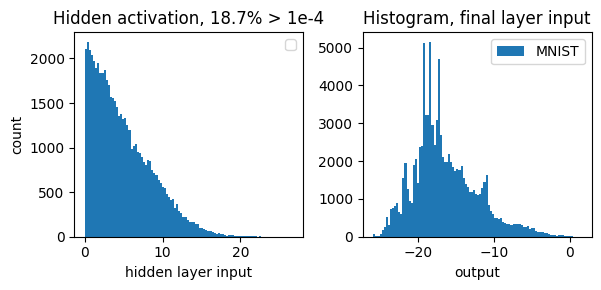

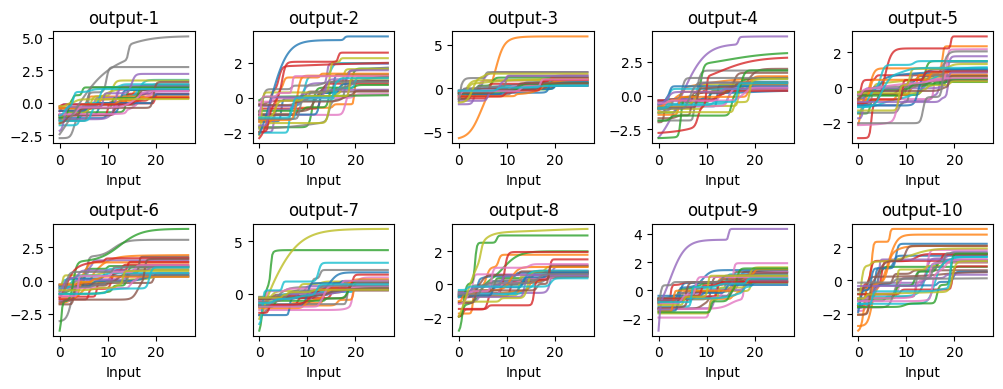

 Epoch 21/80, Loss: 0.1869, Accuracy: 93.99%


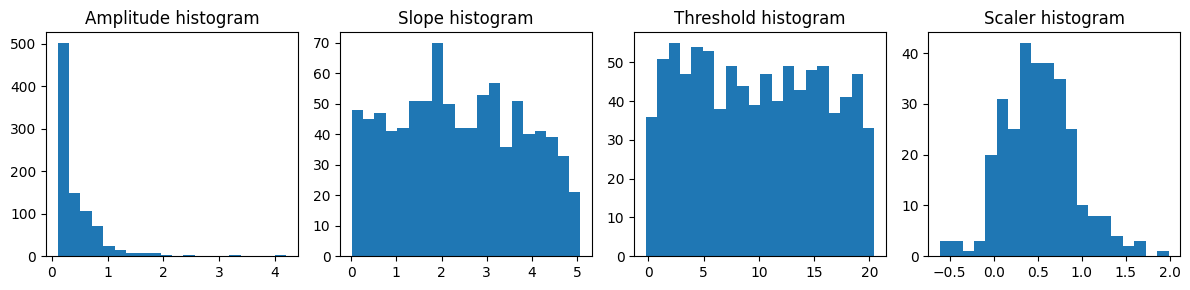

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


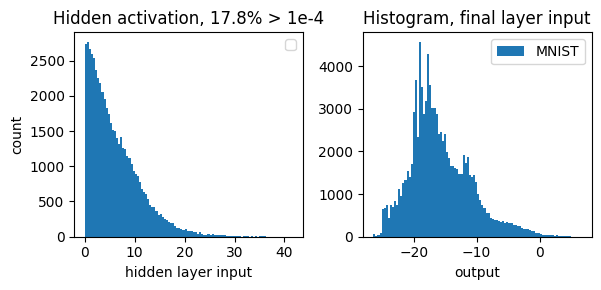

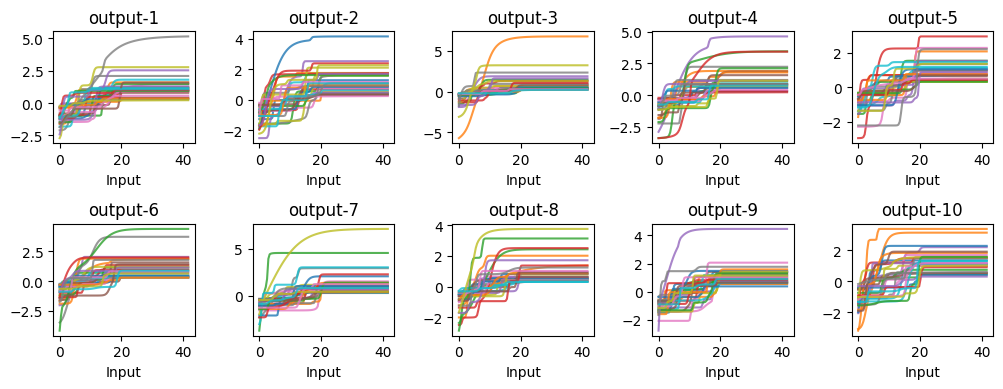

 Epoch 31/80, Loss: 0.1650, Accuracy: 94.50%


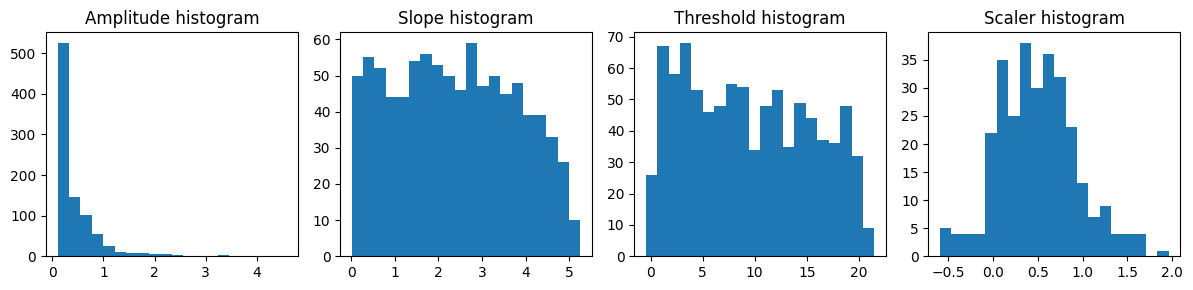

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


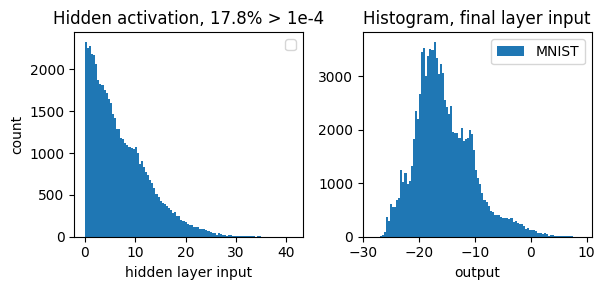

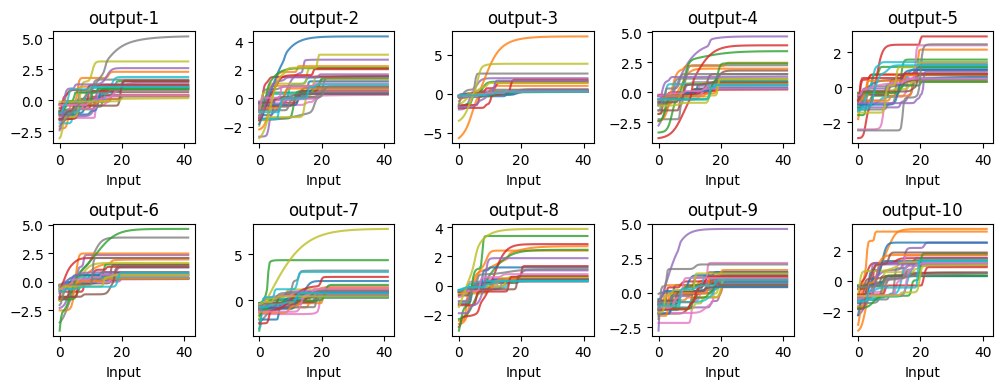

 Epoch 41/80, Loss: 0.1530, Accuracy: 94.54%


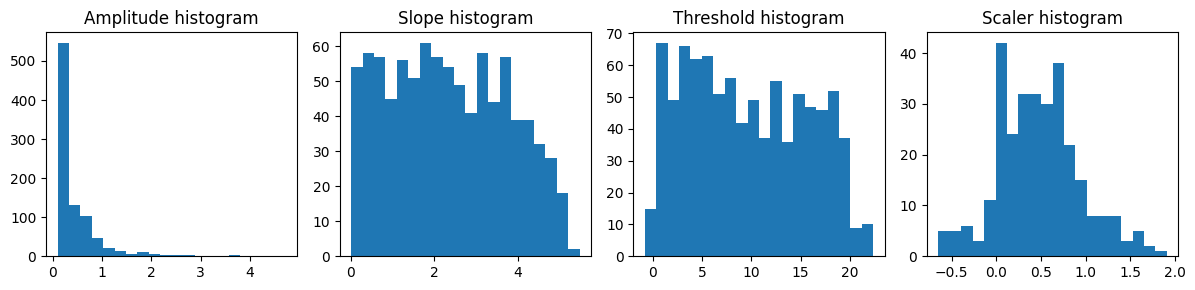

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


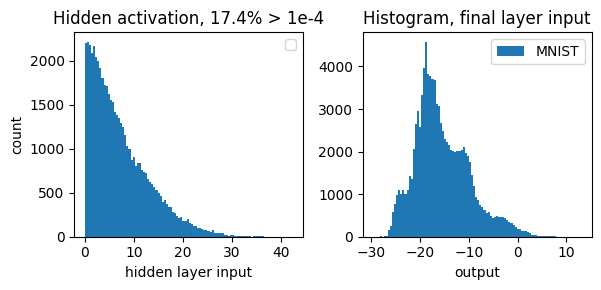

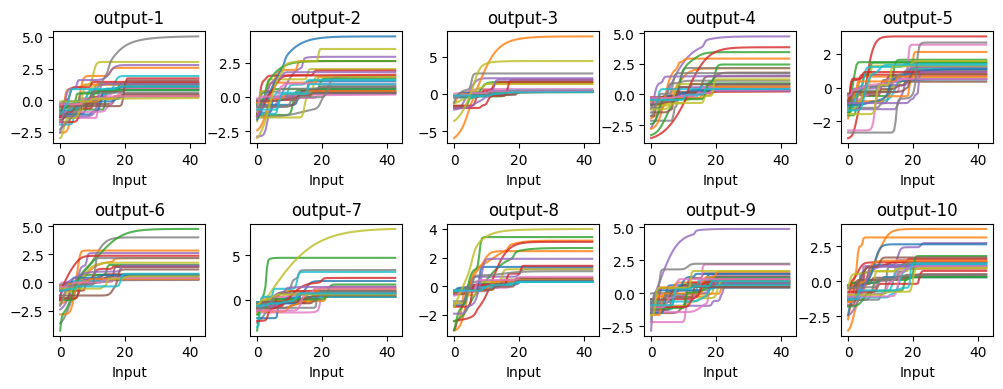

KeyboardInterrupt: 

In [15]:
result = []
for i in range(10):
    torch.manual_seed(i)
    model = ParallelSynapse2NN(
        input_dim, 
        n_synapse, 
        hidden_dim, 
        output_dim, 
        hidden_range
    )
    result.append(train_models_NN(model, trainloader, testloader, num_epochs = 80, verbose = True, regularization=0))
    plot_parallel_synapse_params(model)
    plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act='relu')
    
    

    with open('result_parallel_softmax.pickle', 'wb') as f:
        pickle.dump(result, f)
    print('--------------------------------------------------')

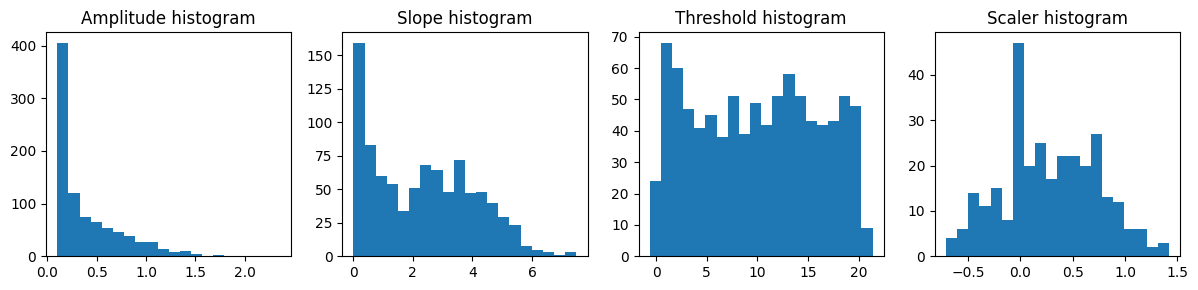

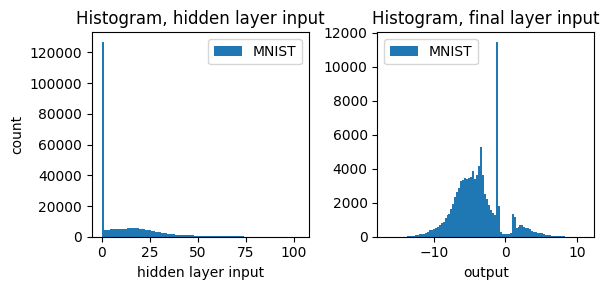

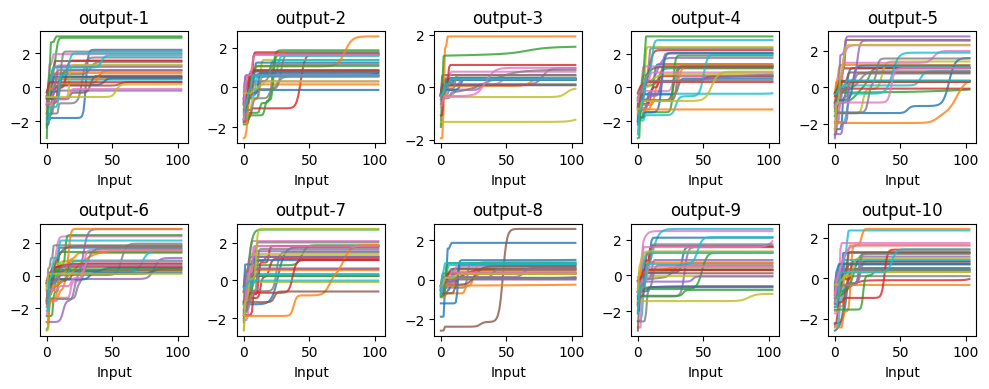

In [47]:
plot_parallel_synapse_params(model)
plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act='relu')


In [49]:
model.parallel_synapse.thres.data.max()

tensor(21.3914)